In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import os
import sys
import shutil

import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection
from itertools import combinations

import matplotlib.pyplot as plt

In [2]:
from scipy.stats import pearsonr
import seaborn as sns

In [3]:
working_dir = 'tmp/'

# File inputs
x_input = 'data/ProCan-DepMapSanger_protein_matrix_6692_averaged.xlsx'
y_input = 'data/DrugResponse_PANCANCER_GDSC1_GDSC2_20200602.csv'

In [4]:
tested_interactions = pd.read_csv(working_dir+"final3_aux.tsv", sep="\t", index_col=False,  names=["coef_id", "coef" ,"std err" ,"z", "P>|z|", "[0.025", 	"0.975]", "converged", "pseudo_r2", "standard_fitting", "snps", "order", "drug"])

C:\Users\wen068\AppData\Local\Temp\ipykernel_18464\3472630815.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  tested_interactions = pd.read_csv(working_dir+"final3_aux.tsv", sep="\t", index_col=False,  names=["coef_id", "coef" ,"std err" ,"z", "P>|z|", "[0.025", 	"0.975]", "converged", "pseudo_r2", "standard_fitting", "snps", "order", "drug"])


In [5]:
proteins = tested_interactions[tested_interactions["coef_id"].str.contains("HUMAN")].copy()
drug_list = np.unique(tested_interactions["drug"])

### Data

In [6]:
#One row per cell line
#DIR
x = pd.read_excel(x_input, engine='openpyxl').drop(columns=['Project_Identifier'])
c = [a.replace(';','.') for a in x.columns]
x.columns = c
x

,Cell_Line,P37108.SRP14_HUMAN,Q96JP5.ZFP91_HUMAN,Q9Y4H2.IRS2_HUMAN,P36578.RL4_HUMAN,Q6SPF0.SAMD1_HUMAN,O76031.CLPX_HUMAN,Q8WUQ7.CATIN_HUMAN,A6NIH7.U119B_HUMAN,Q9BTD8.RBM42_HUMAN,...,P33151.CADH5_HUMAN,Q5EBL4.RIPL1_HUMAN,P49715.CEBPA_HUMAN,Q5TA45.INT11_HUMAN,O14924.RGS12_HUMAN,Q7Z3B1.NEGR1_HUMAN,O60669.MOT2_HUMAN,Q13571.LAPM5_HUMAN,Q96JM2.ZN462_HUMAN,P35558.PCKGC_HUMAN
0,K052,7.109545,3.414941,NaN,7.866614,3.895467,4.196655,NaN,NaN,3.190877,...,NaN,NaN,3.90064,2.639977,NaN,NaN,NaN,NaN,NaN,NaN
1,TE-12,6.828022,4.143455,2.237808,7.628785,3.198109,4.609018,NaN,2.47059,3.695348,...,NaN,NaN,NaN,3.196077,NaN,NaN,NaN,NaN,NaN,NaN
2,TMK-1,7.014256,4.199872,2.440552,8.124585,NaN,4.768811,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,STS-0421,5.285911,3.357894,NaN,7.972680,NaN,4.520923,NaN,NaN,2.730884,...,NaN,NaN,NaN,2.790234,NaN,NaN,NaN,NaN,NaN,NaN
4,PL4,5.707857,NaN,NaN,6.225738,NaN,4.495795,NaN,NaN,2.879809,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944,CGTH-W-1,6.316308,4.869332,NaN,7.624330,3.926891,4.472120,NaN,NaN,3.484641,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
945,H9,6.230865,2.716858,NaN,7.235027,3.420646,4.717799,NaN,NaN,3.625137,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
946,GR-ST,7.004074,NaN,NaN,7.581500,NaN,4.590818,NaN,NaN,3.329604,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
947,YMB-1-E,6.765316,3.757772,NaN,7.241326,3.054766,4.740301,NaN,NaN,2.562678,...,NaN,3.432128,NaN,2.463809,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
x.isna().sum().sum()

3042799

In [7]:
#DIR
y = pd.read_csv(y_input)[['drug_id','cell_line_name','ln_IC50']]
y

C:\Users\wen068\AppData\Local\Temp\ipykernel_18464\1999436348.py:2: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  y = pd.read_csv(y_input)[['drug_id','cell_line_name','ln_IC50']]


,drug_id,cell_line_name,ln_IC50
0,1409,697,-5.452393
1,1057,697,-3.891777
2,1060,697,-0.170167
3,252,697,-2.762333
4,282,697,-2.615651
...,...,...,...
605251,2290,ZR-75-30,6.547607
605252,1735,ZR-75-30,3.195281
605253,1034,ZR-75-30,1.052725
605254,1862,ZR-75-30,1.570232


### Regression

#### Functions

In [8]:
def results_fit_to_df(results):
    coeffs = results.params.tolist()
    pvals = results.pvalues.tolist()
    pseudo_r2 = results.rsquared
    adj_r2 = results.rsquared_adj
    tvals = results.tvalues.tolist()
    mse = results.mse_resid
    cint_low = results.conf_int()[0].tolist()
    cint_high = results.conf_int()[1].tolist()

    try:
        results = results.summary()
    except:
        #ValueError: resids must contain at least 2 elements
        r = pd.DataFrame([1,2,3]) #dirty...
        r['z']='nan'
        return r
    converged = results.tables[0].data[5][1].strip()
    results = results.tables[1].data
    results = pd.DataFrame(results[1:], columns=['coef_id', 'coef', 'std err', 'z', 'P>|z|', '[0.025', '0.975]'])
    results['P>|z|'] = pvals
    results['z'] = tvals 
    results['coef'] = coeffs
    results['converged'] = converged
    results['pseudo_r2'] = pseudo_r2
    results['adj_r2'] = adj_r2
    results["MSE"] = mse
    results['[0.025'] = cint_low
    results['0.975]'] = cint_high
    return results

In [28]:
def regression_per_drug(proteins, drug_list, alpha=0.05, filter=0):
    final_results = []
    j = 0
    for i,d in enumerate(drug_list):  # [[45,76]]
        xy = x.merge(y[y["drug_id"]==d], left_on='Cell_Line', right_on='cell_line_name')
        xy.columns = [''.join([chr(int(y)+97) if y.isnumeric() else y for y in x.replace('_','').replace('.','')]) for x in xy.columns] 
        
        interactions = proteins[proteins["drug"]==d]
        sig = fdrcorrection(interactions["P>|z|"], alpha=alpha, method='indep', is_sorted=False)[0]
        interactions = interactions[sig]
    
        sig_inter = interactions[np.abs(interactions.coef)>=filter][["coef_id", "order"]] # all sig interaction independet from order
        sig_inter["coef_id"] = sig_inter["coef_id"].str.strip("\[01\]")  # remove certain characters
        sig_inter.loc[~sig_inter["coef_id"].str.contains(":"), 'order'] = 1  # denote single proteins as first interaction ( by it self)
        sig_inter = sig_inter.drop_duplicates(ignore_index=True)
        prot_list = [str(y).rstrip("\[01\]") for x in sig_inter["coef_id"] for y in x.split(":")]  # all proteins connected to any sig information (needed for the regression)
        prot_list = np.unique(prot_list).tolist()
        n_prot = len(sig_inter["coef_id"][sig_inter["order"]<=1])

        data = xy[["lnICfa"] + prot_list].fillna(0)
        # with each interation add more interaction information to the regression formula
        for o in range(1,5):
            # print("Order: ", o)
            formular = "lnICfa" + " ~ "
            formular = formular + " + ".join(sig_inter["coef_id"][sig_inter["order"]<=o].drop_duplicates(ignore_index=True))

            try:
                ols = smf.ols(formular,data=data)
            except:
                print('error in OLS, drug', d, "number of variables (+)", formular.count('+') )
                j += 1
                
                break  # we do not need to check any higher order, if the lower order already fails due to recursion depth
            ols.raise_on_perfect_prediction = False #preventing the perfect separation error
            results = ols.fit(disp=False, maxiter=1000) #method prevents singular matrix
            pred_y = ols.predict(results.params)
            pear_R = pearsonr(pred_y, data["lnICfa"].to_list())
            results = results_fit_to_df(results)
            results["order"] = o
            results["drug"] = d
            results["pearsonR"] = pear_R.statistic
            results["n_prot"] = n_prot
            results["MSE"] = np.square(data["lnICfa"].to_list() - pred_y).mean()
            final_results.append(results)
    final_results = pd.concat(final_results)
    print(j/(len(drug_list)), " % of drugs failed OLS at some point")        
    print("The largest amount of proteins used for a regression was: ", final_results.n_prot.max())
    return final_results

In [11]:
def r2_hist(result, title="Histogram of $R^2$ values", save="r_squared", x_label="$R^2$"):
    
    r2 = result.iloc[:,0]
    mu_1 = np.round(r2[result.order == 1].median(axis=0), 3)
    mu_2 = np.round(r2[result.order == 2].median(axis=0), 3)
    mu_3 = np.round(r2[result.order == 3].median(axis=0), 3)
    mu_4 = np.round(r2[result.order == 4].median(axis=0), 3)
    
    fig, ax = plt.subplots()
    
    ax.hist([r2[result.order == 1], r2[result.order == 2], r2[result.order == 3], 
             r2[result.order == 4]], bins=10, alpha=0.7)
    
    ax.legend(["1st order $\mu$ = " + str(mu_1), "2nd order $\mu$ = " + str(mu_2), "3rd order $\mu$ = " + str(mu_3), "4th order $\mu$ = " + str(mu_4)])
    ax.set_xlabel(x_label)
    ax.set_ylabel("Frequency")
    ax.set_title(title)
    plt.savefig(save)
    plt.close()
    # plt.show()
    return

#### Results

In [22]:
r2_5 = regression_per_drug(proteins, drug_list, filter=0.5)

C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

error in OLS, drug 203 number of variables (+) 2383
error in OLS, drug 223 number of variables (+) 1699
error in OLS, drug 253 number of variables (+) 2746
error in OLS, drug 263 number of variables (+) 1685
error in OLS, drug 273 number of variables (+) 2105


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

error in OLS, drug 303 number of variables (+) 2790
error in OLS, drug 333 number of variables (+) 3093
error in OLS, drug 1003 number of variables (+) 2986
error in OLS, drug 1013 number of variables (+) 4191
error in OLS, drug 1033 number of variables (+) 3629
error in OLS, drug 1043 number of variables (+) 2550
error in OLS, drug 1053 number of variables (+) 3444
error in OLS, drug 1073 number of variables (+) 2702
error in OLS, drug 1083 number of variables (+) 2938
error in OLS, drug 1093 number of variables (+) 2753
error in OLS, drug 1133 number of variables (+) 2436
error in OLS, drug 1193 number of variables (+) 2554


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

error in OLS, drug 1373 number of variables (+) 3575


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


error in OLS, drug 1393 number of variables (+) 1821


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


error in OLS, drug 1413 number of variables (+) 1522
error in OLS, drug 1433 number of variables (+) 1545
error in OLS, drug 1453 number of variables (+) 1496


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

error in OLS, drug 1563 number of variables (+) 3064


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

error in OLS, drug 1633 number of variables (+) 1721


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

error in OLS, drug 1873 number of variables (+) 2362
error in OLS, drug 1913 number of variables (+) 2699
error in OLS, drug 1933 number of variables (+) 2865
error in OLS, drug 1973 number of variables (+) 2372
error in OLS, drug 1993 number of variables (+) 2145


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

error in OLS, drug 2023 number of variables (+) 2388
error in OLS, drug 2043 number of variables (+) 2783


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


error in OLS, drug 2063 number of variables (+) 1950


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

error in OLS, drug 2103 number of variables (+) 1590
error in OLS, drug 2153 number of variables (+) 2178
error in OLS, drug 2163 number of variables (+) 2298
error in OLS, drug 2173 number of variables (+) 2891


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

error in OLS, drug 2273 number of variables (+) 1880
error in OLS, drug 2283 number of variables (+) 1814
error in OLS, drug 2293 number of variables (+) 1595


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

error in OLS, drug 2313 number of variables (+) 1568


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


error in OLS, drug 2323 number of variables (+) 2202
error in OLS, drug 2333 number of variables (+) 2146


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


error in OLS, drug 2363 number of variables (+) 1502
error in OLS, drug 2503 number of variables (+) 2639
0.5569620253164557  % of drugs failed OLS at some point
The largest amount of proteins used for a regression was:  1453


In [23]:
len(r2_5[["drug"]].drop_duplicates())

40

In [24]:
r2_5.to_csv(working_dir+"r2_5.csv", index=False)

<Axes: xlabel='n_prot', ylabel='pseudo_r2'>

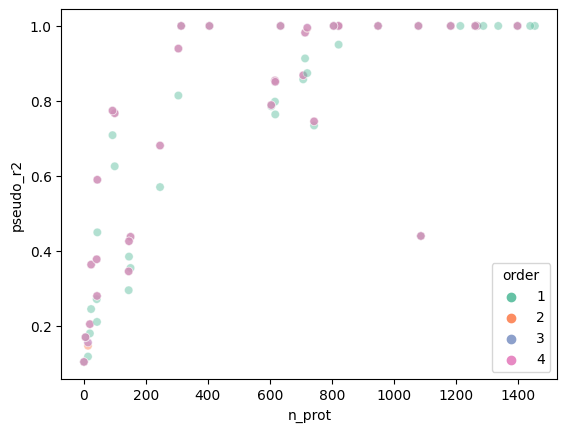

In [25]:
sns.scatterplot(data=r2_5[["adj_r2", "pseudo_r2", "order", "n_prot"]].drop_duplicates(ignore_index=True), x="n_prot", y="pseudo_r2", hue="order", palette="Set2", alpha=0.5)

<Axes: xlabel='n_prot', ylabel='pearsonR'>

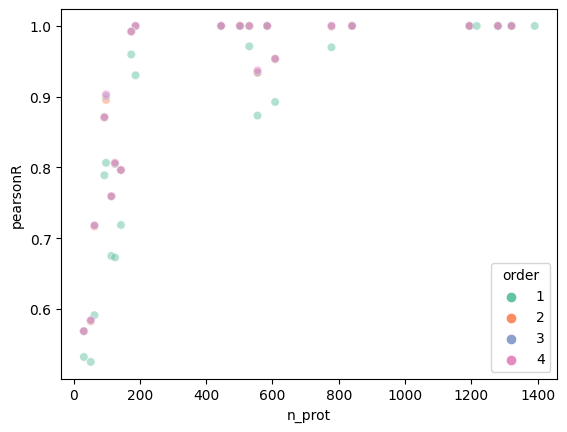

In [100]:
sns.scatterplot(data=r2_5[["pearsonR", "adj_r2", "pseudo_r2", "order", "n_prot"]].drop_duplicates(ignore_index=True), x="n_prot", y="pearsonR", hue="order", palette="Set2", alpha=0.5)

<Axes: xlabel='n_prot', ylabel='adj_r2'>

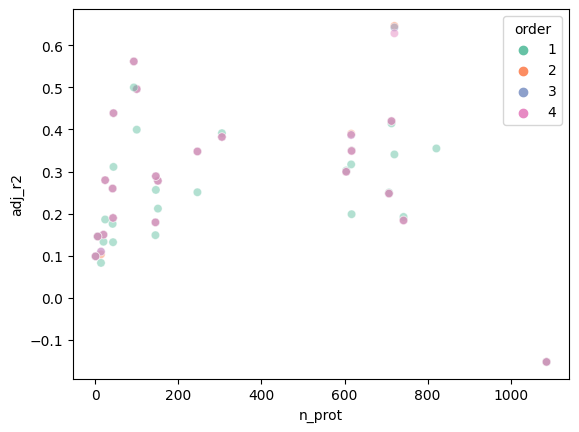

In [26]:
# adj includes nan if to few observations for amount of variables
sns.scatterplot(data=r2_5[["adj_r2", "pseudo_r2", "order", "n_prot"]].drop_duplicates(ignore_index=True), x="n_prot", y="adj_r2", hue="order", palette="Set2", alpha=0.5) 

In [74]:
r2_hist(r2_5[["adj_r2", "order", "drug"]].drop_duplicates(ignore_index=True), "adj $R^2$, |Coef| > 0.5", "r2_adj_005-05")
r2_hist(r2_5[["pseudo_r2", "order", "drug"]].drop_duplicates(ignore_index=True), "|Coef| > 0.5", "r2_005-05")
r2_hist(r2_5[["pearsonR", "order", "drug"]].drop_duplicates(ignore_index=True), "Pearson's r, |Coef| > 0.5", "pR_005-05", x_label="Pearson's r")

63
52
114
125
555
778


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


608
1280


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

2149
error in OLS, drug  193 number of variables (+) 2148
2962
error in OLS, drug  203 number of variables (+) 2961
2260
error in OLS, drug  223 number of variables (+) 2259
3170
error in OLS, drug  253 number of variables (+) 3169
2539
error in OLS, drug  263 number of variables (+) 2538
2572
error in OLS, drug  273 number of variables (+) 2571
1805
error in OLS, drug  283 number of variables (+) 1804
1391


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


error in OLS, drug 293 number of variables (+) 1534
error in OLS, drug 293 number of variables (+) 1539
error in OLS, drug 293 number of variables (+) 1541
3101
error in OLS, drug  303 number of variables (+) 3100
3384
error in OLS, drug  333 number of variables (+) 3383
1321


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

1971
error in OLS, drug  563 number of variables (+) 1970
1978
error in OLS, drug  573 number of variables (+) 1977
3340
error in OLS, drug  1003 number of variables (+) 3339
4419
error in OLS, drug  1013 number of variables (+) 4418
2804
error in OLS, drug  1023 number of variables (+) 2803
3990
error in OLS, drug  1033 number of variables (+) 3989
3582
error in OLS, drug  1043 number of variables (+) 3581
3993
error in OLS, drug  1053 number of variables (+) 3992
3082
error in OLS, drug  1073 number of variables (+) 3081
3306
error in OLS, drug  1083 number of variables (+) 3305
3246
error in OLS, drug  1093 number of variables (+) 3245
3480
error in OLS, drug  1133 number of variables (+) 3479
143
2982
error in OLS, drug  1193 number of variables (+) 2981
1194


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

1889
error in OLS, drug  1243 number of variables (+) 1888
2152
error in OLS, drug  1263 number of variables (+) 2151
3945
error in OLS, drug  1373 number of variables (+) 3944
2295
error in OLS, drug  1393 number of variables (+) 2294
1636
error in OLS, drug  1403 number of variables (+) 1635
2142
error in OLS, drug  1413 number of variables (+) 2141
2460
error in OLS, drug  1433 number of variables (+) 2459
1998
error in OLS, drug  1453 number of variables (+) 1997
1722
error in OLS, drug  1463 number of variables (+) 1721
584


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

187


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

3466
error in OLS, drug  1563 number of variables (+) 3465
840


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

174
2112
error in OLS, drug  1633 number of variables (+) 2111
502


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

31
3070
error in OLS, drug  1873 number of variables (+) 3069
3265
error in OLS, drug  1913 number of variables (+) 3264
98
3284
error in OLS, drug  1933 number of variables (+) 3283
2784
error in OLS, drug  1973 number of variables (+) 2783
2495
error in OLS, drug  1993 number of variables (+) 2494
1652
error in OLS, drug  2013 number of variables (+) 1651
2735
error in OLS, drug  2023 number of variables (+) 2734
3276
error in OLS, drug  2043 number of variables (+) 3275
1994
error in OLS, drug  2063 number of variables (+) 1993
1995
error in OLS, drug  2093 number of variables (+) 1994
2108
error in OLS, drug  2103 number of variables (+) 2107
2440
error in OLS, drug  2153 number of variables (+) 2439
2637
error in OLS, drug  2163 number of variables (+) 2636
3292
error in OLS, drug  2173 number of variables (+) 3291
445


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

1216


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


error in OLS, drug 2243 number of variables (+) 1713
error in OLS, drug 2243 number of variables (+) 1716
error in OLS, drug 2243 number of variables (+) 1720
530


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

2414
error in OLS, drug  2273 number of variables (+) 2413
2307
error in OLS, drug  2283 number of variables (+) 2306
1857
error in OLS, drug  2293 number of variables (+) 1856
1610
error in OLS, drug  2303 number of variables (+) 1609
2077
error in OLS, drug  2313 number of variables (+) 2076
1644
error in OLS, drug  2323 number of variables (+) 1643
2574
error in OLS, drug  2333 number of variables (+) 2573
1494
error in OLS, drug  2363 number of variables (+) 1493
93
3028
error in OLS, drug  2503 number of variables (+) 3027
0.1962025316455696  percentage failed OLS


In [29]:
r2_05 = regression_per_drug(proteins, drug_list)

C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

error in OLS, drug 193 number of variables (+) 1485
error in OLS, drug 203 number of variables (+) 2425
error in OLS, drug 223 number of variables (+) 1705
error in OLS, drug 253 number of variables (+) 2844
error in OLS, drug 263 number of variables (+) 1798
error in OLS, drug 273 number of variables (+) 2112


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


error in OLS, drug 283 number of variables (+) 2032
error in OLS, drug 303 number of variables (+) 2796
error in OLS, drug 333 number of variables (+) 3161


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

error in OLS, drug 1003 number of variables (+) 2991
error in OLS, drug 1013 number of variables (+) 4211
error in OLS, drug 1023 number of variables (+) 1766
error in OLS, drug 1033 number of variables (+) 3740
error in OLS, drug 1043 number of variables (+) 2682
error in OLS, drug 1053 number of variables (+) 3470
error in OLS, drug 1073 number of variables (+) 2704
error in OLS, drug 1083 number of variables (+) 2948
error in OLS, drug 1093 number of variables (+) 2789
error in OLS, drug 1133 number of variables (+) 2498
error in OLS, drug 1193 number of variables (+) 2559


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

error in OLS, drug 1263 number of variables (+) 1765
error in OLS, drug 1373 number of variables (+) 3579


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


error in OLS, drug 1393 number of variables (+) 3007
error in OLS, drug 1403 number of variables (+) 1502


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


error in OLS, drug 1413 number of variables (+) 2430
error in OLS, drug 1433 number of variables (+) 1645
error in OLS, drug 1453 number of variables (+) 1514


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

error in OLS, drug 1563 number of variables (+) 3119


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

error in OLS, drug 1633 number of variables (+) 1722


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

error in OLS, drug 1873 number of variables (+) 2445
error in OLS, drug 1913 number of variables (+) 2779
error in OLS, drug 1933 number of variables (+) 2873
error in OLS, drug 1973 number of variables (+) 2374
error in OLS, drug 1993 number of variables (+) 2146


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


error in OLS, drug 2013 number of variables (+) 1740
error in OLS, drug 2023 number of variables (+) 2401
error in OLS, drug 2043 number of variables (+) 2864


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


error in OLS, drug 2063 number of variables (+) 2562


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


error in OLS, drug 2093 number of variables (+) 1928
error in OLS, drug 2103 number of variables (+) 1609
error in OLS, drug 2153 number of variables (+) 2178
error in OLS, drug 2163 number of variables (+) 2316
error in OLS, drug 2173 number of variables (+) 2916


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

error in OLS, drug 2243 number of variables (+) 1617
error in OLS, drug 2273 number of variables (+) 1912
error in OLS, drug 2283 number of variables (+) 1824
error in OLS, drug 2293 number of variables (+) 1595


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmo

error in OLS, drug 2313 number of variables (+) 1572


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


error in OLS, drug 2323 number of variables (+) 2848
error in OLS, drug 2333 number of variables (+) 2157


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


error in OLS, drug 2363 number of variables (+) 2302
error in OLS, drug 2503 number of variables (+) 2689
0.6582278481012658  % of drugs failed OLS at some point
The largest amount of proteins used for a regression was:  1463


In [30]:
len(r2_05[["drug"]].drop_duplicates())

38

In [31]:
r2_05.to_csv(working_dir+"baseline.csv", index=False)

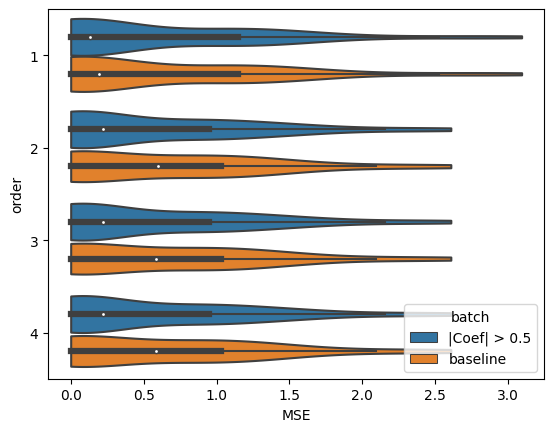

In [33]:
r2_5["batch"] = "|Coef| > 0.5"
r2_05["batch"] = "baseline"

r_combined = pd.concat([r2_5, r2_05], ignore_index=True)
r_combined = r_combined[["MSE", "pearsonR", "order", "drug", "batch"]].drop_duplicates(ignore_index=True)
sns.violinplot(data=r_combined, x="MSE", y="order", hue="batch", cut=0, orient="h" )
plt.savefig(working_dir+"img/mse.png")

In [52]:
r2_hist(r2_05[["adj_r2", "order", "drug"]].drop_duplicates(ignore_index=True), "adj $R^2$, alpha = 0.05", working_dir+"img/r2_adj_005")
r2_hist(r2_05[["pseudo_r2", "order", "drug"]].drop_duplicates(ignore_index=True), "alpha = 0.05", working_dir+"img/r2_005")

r2_hist(r2_05[["pearsonR", "order", "drug"]].drop_duplicates(ignore_index=True), "Pearson\'s r", working_dir+"img/pR_005", x_label="Pearson\'s r")

In [59]:
del r2_05

error in OLS, drug  3
error in OLS, drug  63
error in OLS, drug  83
error in OLS, drug  163
error in OLS, drug  193
error in OLS, drug  193
error in OLS, drug  193
error in OLS, drug  203
error in OLS, drug  223
error in OLS, drug  253
error in OLS, drug  263
error in OLS, drug  273
error in OLS, drug  303
error in OLS, drug  333
error in OLS, drug  1003
error in OLS, drug  1013
error in OLS, drug  1033
error in OLS, drug  1043
error in OLS, drug  1053
error in OLS, drug  1073
error in OLS, drug  1083
error in OLS, drug  1093
error in OLS, drug  1133
error in OLS, drug  1193
error in OLS, drug  1263
error in OLS, drug  1373
error in OLS, drug  1393
error in OLS, drug  1393
error in OLS, drug  1393
error in OLS, drug  1413
error in OLS, drug  1413
error in OLS, drug  1413
error in OLS, drug  1433
error in OLS, drug  1453
error in OLS, drug  1563


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\stats

error in OLS, drug  1633


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\stats

error in OLS, drug  1853
error in OLS, drug  1873
error in OLS, drug  1913
error in OLS, drug  1933
error in OLS, drug  1973
error in OLS, drug  1993
error in OLS, drug  2023
error in OLS, drug  2043
error in OLS, drug  2063
error in OLS, drug  2063
error in OLS, drug  2063
error in OLS, drug  2103
error in OLS, drug  2153
error in OLS, drug  2163
error in OLS, drug  2173


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\stats

error in OLS, drug  2273
error in OLS, drug  2283
error in OLS, drug  2293
error in OLS, drug  2313
error in OLS, drug  2323
error in OLS, drug  2333
error in OLS, drug  2363
error in OLS, drug  2463
error in OLS, drug  2503
       adj_r2  order  drug
0    0.017865      1    53
1    0.017865      2    53
2    0.017865      3    53
3    0.017865      4    53
4    0.091678      1   133
..        ...    ...   ...
107  0.258243      4  2253
108  0.371835      1  2303
109  0.472916      2  2303
110  0.481190      3  2303
111  0.481190      4  2303

[112 rows x 3 columns]
0      0.017865
1      0.017865
2      0.017865
3      0.017865
4      0.091678
         ...   
107    0.258243
108    0.371835
109    0.472916
110    0.481190
111    0.481190
Name: adj_r2, Length: 112, dtype: float64


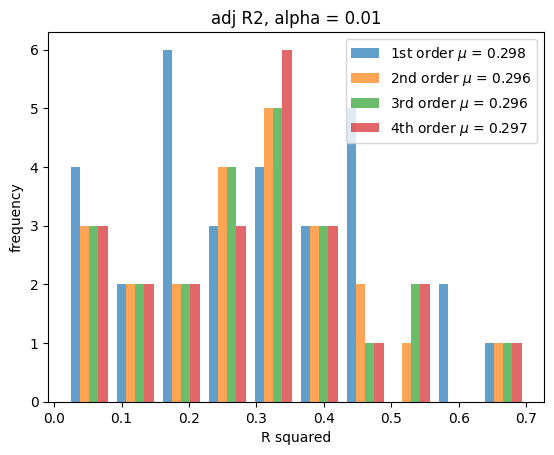

     pseudo_r2  order  drug
0     0.020456      1    53
1     0.020456      2    53
2     0.020456      3    53
3     0.020456      4    53
4     0.100329      1   133
..         ...    ...   ...
107   0.336525      4  2253
108   0.599784      1  2303
109   0.760549      2  2303
110   0.766464      3  2303
111   0.766464      4  2303

[112 rows x 3 columns]
0      0.020456
1      0.020456
2      0.020456
3      0.020456
4      0.100329
         ...   
107    0.336525
108    0.599784
109    0.760549
110    0.766464
111    0.766464
Name: pseudo_r2, Length: 112, dtype: float64


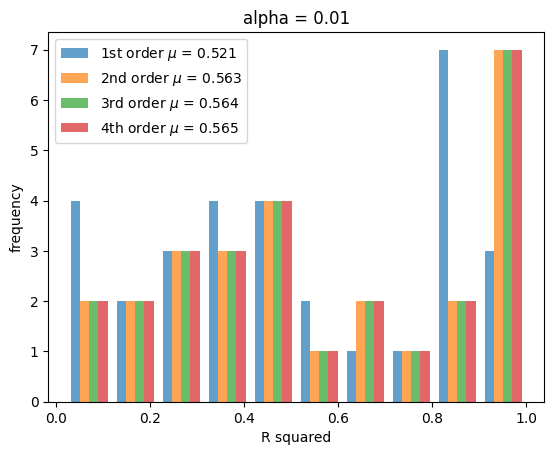

In [51]:
r2_01 = regression_per_drug(proteins, drug_list, 0.01)
r2_hist(r2_01[["adj_r2", "order", "drug"]].drop_duplicates(ignore_index=True), "adj $R^2$, alpha = 0.01", working_dir+"img/r2_adj_001")
r2_hist(r2_01[["pseudo_r2", "order", "drug"]].drop_duplicates(ignore_index=True), "alpha = 0.01", working_dir+"img/r2_001")

In [58]:
del r2_01

error in OLS, drug  3
error in OLS, drug  53
error in OLS, drug  63
error in OLS, drug  83
error in OLS, drug  133
error in OLS, drug  163
error in OLS, drug  203
error in OLS, drug  253
error in OLS, drug  273
error in OLS, drug  303
error in OLS, drug  333
error in OLS, drug  1003
error in OLS, drug  1013
error in OLS, drug  1033
error in OLS, drug  1053
error in OLS, drug  1073
error in OLS, drug  1083
error in OLS, drug  1093
error in OLS, drug  1143
error in OLS, drug  1193
error in OLS, drug  1373
error in OLS, drug  1563
error in OLS, drug  1853
error in OLS, drug  1873
error in OLS, drug  1873
error in OLS, drug  1873
error in OLS, drug  1913
error in OLS, drug  1923
error in OLS, drug  1933
error in OLS, drug  1973
error in OLS, drug  1993
error in OLS, drug  1993
error in OLS, drug  1993
error in OLS, drug  2023
error in OLS, drug  2043


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\stats

error in OLS, drug  2153
error in OLS, drug  2163
error in OLS, drug  2173
error in OLS, drug  2273
error in OLS, drug  2273
error in OLS, drug  2273


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\stats

error in OLS, drug  2293
error in OLS, drug  2293
error in OLS, drug  2293
error in OLS, drug  2333


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\stats

error in OLS, drug  2463
error in OLS, drug  2503
       adj_r2  order  drug
0    0.050753      1   153
1    0.050753      2   153
2    0.050753      3   153
3    0.050753      4   153
4    0.127558      1   173
..        ...    ...   ...
159  0.473830      4  2323
160  0.535317      1  2363
161       NaN      2  2363
162       NaN      3  2363
163       NaN      4  2363

[164 rows x 3 columns]
0      0.050753
1      0.050753
2      0.050753
3      0.050753
4      0.127558
         ...   
159    0.473830
160    0.535317
161         NaN
162         NaN
163         NaN
Name: adj_r2, Length: 164, dtype: float64


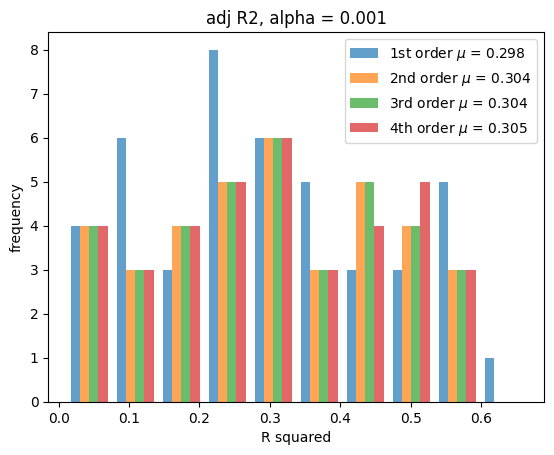

     pseudo_r2  order  drug
0     0.052984      1   153
1     0.052984      2   153
2     0.052984      3   153
3     0.052984      4   153
4     0.170294      1   173
..         ...    ...   ...
159   0.933442      4  2323
160   0.897719      1  2363
161   1.000000      2  2363
162   1.000000      3  2363
163   1.000000      4  2363

[164 rows x 3 columns]
0      0.052984
1      0.052984
2      0.052984
3      0.052984
4      0.170294
         ...   
159    0.933442
160    0.897719
161    1.000000
162    1.000000
163    1.000000
Name: pseudo_r2, Length: 164, dtype: float64


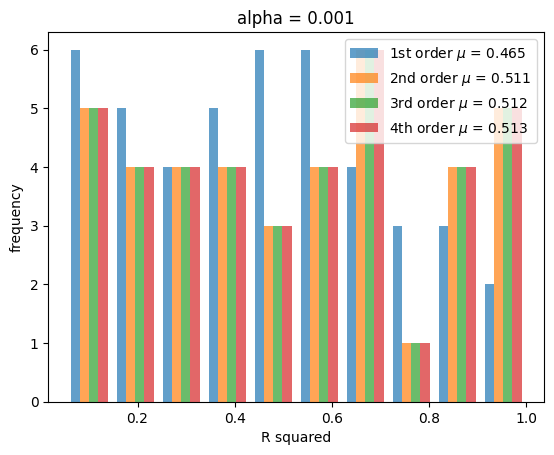

In [52]:
r2_001 = regression_per_drug(proteins, drug_list, 0.001)
r2_hist(r2_001[["adj_r2", "order", "drug"]].drop_duplicates(ignore_index=True), "adj $R^2$, alpha = 0.001", working_dir+"img/r2_adj_0001")
r2_hist(r2_001[["pseudo_r2", "order", "drug"]].drop_duplicates(ignore_index=True), "alpha = 0.001", working_dir+"img/r2_0001")

In [57]:
del r2_001

In [64]:
del r2_5